In [1]:
import requests
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


In [4]:
(input_train, target_train), (input_test, target_test) = tf.keras.datasets.mnist.load_data("/Users/dominik.waibel/Desktop/mnist.npz")

In [6]:
print(np.shape(input_train))

(60000, 28, 28)


In [7]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [8]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [9]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [11]:
# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

In [12]:
# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [13]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization[0][0]        
____________________________________________________________________________________________

In [14]:
# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [15]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 8)         1160

In [16]:

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 17208     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9137      
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


In [17]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [18]:
# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 24s 504us/sample - loss: 272.5509 - val_loss: 222.4025
Epoch 2/100
48000/48000 [==============================] - 23s 476us/sample - loss: 173.1439 - val_loss: 166.0593
Epoch 3/100
48000/48000 [==============================] - 23s 480us/sample - loss: 165.1994 - val_loss: 161.1897
Epoch 4/100
48000/48000 [==============================] - 23s 478us/sample - loss: 162.0137 - val_loss: 159.8377
Epoch 5/100
48000/48000 [==============================] - 23s 481us/sample - loss: 160.4215 - val_loss: 158.5232
Epoch 6/100
48000/48000 [==============================] - 22s 465us/sample - loss: 159.1696 - val_loss: 156.8909
Epoch 7/100
48000/48000 [==============================] - 22s 466us/sample - loss: 158.2341 - val_loss: 155.8737
Epoch 8/100
48000/48000 [==============================] -

Epoch 69/100
48000/48000 [==============================] - 23s 477us/sample - loss: 150.0320 - val_loss: 284.7237
Epoch 70/100
48000/48000 [==============================] - 23s 478us/sample - loss: 150.2567 - val_loss: 521.9772
Epoch 71/100
48000/48000 [==============================] - 23s 481us/sample - loss: 150.1934 - val_loss: 149.1647
Epoch 72/100
48000/48000 [==============================] - 23s 480us/sample - loss: 150.3126 - val_loss: 148.3232
Epoch 73/100
48000/48000 [==============================] - 23s 483us/sample - loss: 150.3855 - val_loss: 151.4343
Epoch 74/100
48000/48000 [==============================] - 23s 479us/sample - loss: 150.2643 - val_loss: 149.1725
Epoch 75/100
48000/48000 [==============================] - 23s 480us/sample - loss: 150.3389 - val_loss: 149.0467
Epoch 76/100
48000/48000 [==============================] - 23s 481us/sample - loss: 150.2985 - val_loss: 161.2699
Epoch 77/100
48000/48000 [==============================] - 23s 482us/sample - l

In [19]:
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

In [ ]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

In [20]:
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
        # Show image
        plt.imshow(figure)
        plt.show()

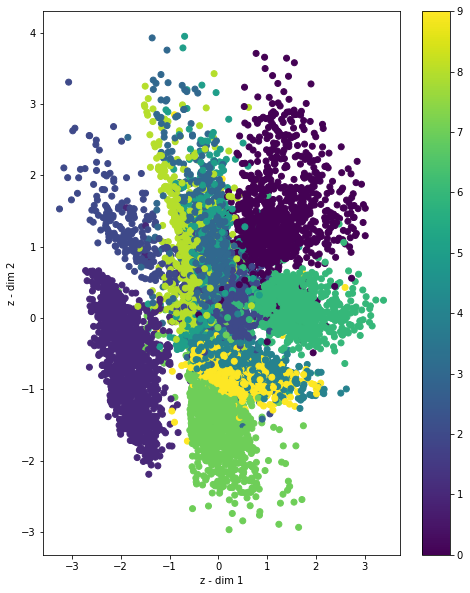

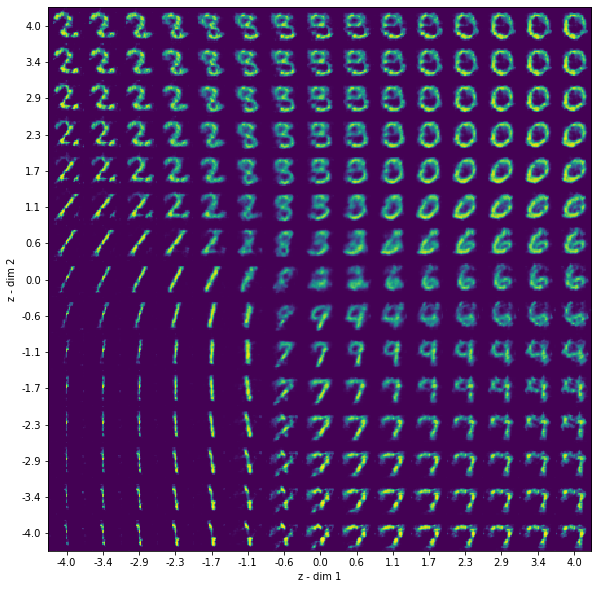

In [21]:
viz_decoded(encoder, decoder, data)